ResNet-18 with Keras Layers

In [12]:
import tensorflow as tf

class ResBlock(tf.keras.Model):
    def __init__(self, filters, downsample=False):
        super(ResBlock, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(filters, 3, padding='same')
        self.act1 = tf.keras.layers.Activation('relu')
        
        self.conv2 = tf.keras.layers.Conv2D(filters, 3, padding='same')
        self.act2 = tf.keras.layers.Activation('relu')
        
        self.add = tf.keras.layers.Add()

        self.downsample = downsample
        if self.downsample:
            self.ds = tf.keras.layers.Conv2D(filters, strides=2, kernel_size=(1, 1), padding='same')
        
    def call(self, inputs):
        ds = inputs
        if self.downsample:
            ds = self.ds(inputs)
        
        x = self.conv1(ds)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.act2(x)
        
        x = self.add([x, ds])
        output = x
        
        return output

In [22]:
class ResNet18(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(64, strides=2, kernel_size=7, padding='same')
        self.act1 = tf.keras.layers.Activation('relu')
        self.maxp = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2)

        self.conv2_1 = ResBlock(64, downsample=False)
        self.conv2_2 = ResBlock(64, downsample=False)

        self.conv3_1 = ResBlock(128, downsample=True)
        self.conv3_2 = ResBlock(128, downsample=False)

        self.conv4_1 = ResBlock(256, downsample=True)
        self.conv4_2 = ResBlock(256, downsample=False)
        
        self.conv5_1 = ResBlock(512, downsample=True)
        self.conv5_2 = ResBlock(512, downsample=False)

        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.flat = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.act1(x)
        x = self.maxp(x)

        for resblock in [self.conv2_1, self.conv2_2, self.conv3_1, self.conv3_2, self.conv4_1, self.conv4_2, self.conv5_1, self.conv5_2]:
            x = resblock(x)
        
        x = self.avg_pool(x)
        x = self.flat(x)
        out = self.fc(x)

        return out

In [23]:
model = ResNet18(10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

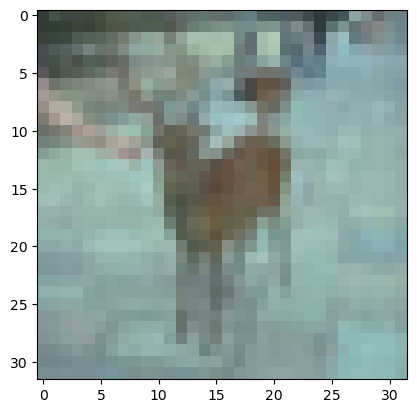

In [17]:
import matplotlib.pyplot as plt
plt.imshow(X_train[153])

In [18]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)

In [20]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

In [26]:
# model.fit(X_train, Y_train, batch_size=256, epochs=10, validation_data=(X_val, Y_val))

from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05, height_shift_range=0.05)
aug.fit(X_train)
model.fit(aug.flow(X_train, Y_train, batch_size=256), epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10


2023-07-07 10:59:30.437513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


KeyboardInterrupt: 

In [25]:
model.evaluate(X_test, Y_test) # 최종 accuracy
model.summary()

313/313 [==============================] - 5s 15ms/step - loss: 1.8040 - accuracy: 0.3153
Model: "res_net18_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          multiple                  9472      
                                                                 
 activation_26 (Activation)  multiple                  0         
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 res_block_16 (ResBlock)     multiple                  73856     
                                                                 
 res_block_17 (ResBlock)     multiple                  73856     
                                                                 
 res_block_18 (ResBlock)     mu